In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
#from simsetup import get_sim
#from modelfitting import ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [10]:
dataset = pd.read_csv('../modeldata/AllFeatMod.csv')

In [11]:
dataset = dataset.drop('logInstT3BR', axis=1)

In [12]:
def hasnull(row):
    numnulls = row.isnull().sum()
    if numnulls == 0:
        return 0
    else:
        return 1

def tmax(row):
    #sim = get_sim(row, csvfolder)
    tmax = 1e4 # replace with a calculation of tmax
    return tmax

In [13]:
%%time
if 'hasnull' not in dataset.columns:
    dataset['hasnull'] = dataset.apply(hasnull, axis=1)
    #dataset['tmax'] = dataset.apply(tmax, axis=1)
    # dataset['tmax'] = dataset.apply(lambda x:1e4, axis=1) # this version would just set tmax=1e4 for all of them

    #dataset.to_csv(trainingdatafolder+"trainingdata.csv", encoding='ascii')

CPU times: user 6.01 s, sys: 63.8 ms, total: 6.07 s
Wall time: 6.07 s


In [14]:
dataset['log']= np.log10(dataset['ThetaSTD']/1.8)

In [15]:
dataset.describe()


,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,MMRstrengthWMAXnear,twoMMRstrengthWnear,twoMMRstrengthWMAXnear,...,Zval12,Zcrit12,Zval23,Zcrit23,IntZval12,IntZval23,instability_time,shadow_instability_time,hasnull,log
count,138543.000000,138543.000000,132454.000000,1.324540e+05,1.324540e+05,132454.000000,1.324540e+05,1.385430e+05,132454.000000,1.385430e+05,...,138543.000000,1.385430e+05,138543.000000,1.385430e+05,138543.000000,138543.000000,1.385430e+05,1.385430e+05,138543.000000,132454.000000
mean,69271.000000,0.150181,0.036880,1.066647e-03,5.761820e-01,0.028574,7.411635e-03,4.384442e+03,0.007147,4.384530e+03,...,0.041550,1.533403e+39,0.037679,6.179803e+41,0.043499,0.039501,2.863147e+08,2.925407e+08,0.043950,-0.142931
std,39994.063509,0.112919,0.058948,3.346593e-03,1.940885e+00,0.372921,3.719930e-02,1.119003e+06,0.036906,1.119026e+06,...,0.050787,5.474334e+41,0.041510,2.300197e+44,0.050699,0.041545,4.371732e+08,4.417942e+08,0.204985,0.792434
min,0.000000,0.004612,0.000042,1.203846e-07,3.522836e-10,0.000000,1.188077e-09,2.992723e-09,0.000000,0.000000e+00,...,0.000010,1.313949e+00,0.000003,1.055361e+00,0.000004,0.000013,3.464102e-02,0.000000e+00,0.000000,-2.810855
25%,34635.500000,0.072493,0.008452,6.633311e-05,5.147461e-02,0.006274,1.535091e-03,2.333482e-03,0.001561,2.069054e-03,...,0.010355,1.759611e+00,0.010037,1.746584e+00,0.012074,0.011703,6.485543e+04,5.858617e+04,0.000000,-0.741346
50%,69271.000000,0.118127,0.021203,2.057084e-04,1.374293e-01,0.015545,3.815094e-03,5.502858e-03,0.003787,4.951063e-03,...,0.024657,3.131623e+00,0.023521,3.089374e+00,0.027096,0.025865,1.484704e+06,1.498063e+06,0.000000,-0.271731
75%,103906.500000,0.186970,0.043551,6.998769e-04,4.418165e-01,0.029844,9.109145e-03,1.205000e-02,0.008489,1.101054e-02,...,0.052984,1.803686e+01,0.050048,1.809699e+01,0.055553,0.052311,1.000000e+09,1.000000e+09,0.000000,0.579132
max,138542.000000,0.982453,6.443866,1.338610e-01,2.563492e+02,77.487085,8.549743e+00,3.896973e+08,8.549917,3.897052e+08,...,0.703917,2.035996e+44,0.465614,8.561648e+46,0.703917,0.466517,1.000050e+09,1.000050e+09,1.000000,2.028211


In [16]:
dataset.columns

Index(['index', 'EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear',
       'twoMMRstrengthnear', 'MMRstrengthWnear', 'MMRstrengthWMAXnear',
       'twoMMRstrengthWnear', 'twoMMRstrengthWMAXnear', 'EMcrossfar',
       'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar', 'twoMMRstrengthfar',
       'MMRstrengthWfar', 'MMRstrengthWMAXfar', 'twoMMRstrengthWfar',
       'twoMMRstrengthWMAXfar', 'EMcrossouter', 'EMfracstdouter', 'EPstdouter',
       'MMRstrengthouter', 'twoMMRstrengthouter', 'MMRstrengthWouter',
       'MMRstrengthWMAXouter', 'twoMMRstrengthWouter',
       'twoMMRstrengthWMAXouter', 'MEGNO', 'MEGNOstd', 'threeBRfillfac',
       'threeBRfillstd', 'chiSec', 'ThetaSTD', 'p2/1', 'p3/2', 'Zval12',
       'Zcrit12', 'Zval23', 'Zcrit23', 'IntZval12', 'IntZval23',
       'prelimStable', 'Stable', 'instability_time', 'shadow_instability_time',
       'hasnull', 'log'],
      dtype='object')

In [17]:
IntDat = ['threeBRfillfac','log','Zcrit12','Zcrit23','IntZval12','IntZval23','MEGNO','EMcrossnear','EMcrossfar']
Dat = ['threeBRfillfac','log','Zcrit12','Zcrit23','Zval12','Zval23','MEGNO','EMcrossnear','EMcrossfar']
all = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear',
       'twoMMRstrengthnear', 'MMRstrengthWnear', 'MMRstrengthWMAXnear',
       'twoMMRstrengthWnear', 'twoMMRstrengthWMAXnear', 'EMcrossfar',
       'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar', 'twoMMRstrengthfar',
       'MMRstrengthWfar', 'MMRstrengthWMAXfar', 'twoMMRstrengthWfar',
       'twoMMRstrengthWMAXfar', 'EMcrossouter', 'EMfracstdouter', 'EPstdouter',
       'MMRstrengthouter', 'twoMMRstrengthouter', 'MMRstrengthWouter',
       'MMRstrengthWMAXouter', 'twoMMRstrengthWouter',
       'twoMMRstrengthWMAXouter', 'MEGNO', 'MEGNOstd', 'threeBRfillfac',
       'threeBRfillstd', 'chiSec', 'ThetaSTD', 'p2/1', 'p3/2', 'Zval12',
       'Zcrit12', 'Zval23', 'Zcrit23', 'IntZval12', 'IntZval23',]

In [18]:
mask = (dataset['hasnull'] == 0 )
filtData = dataset[mask]

In [19]:
filtData.columns

Index(['index', 'EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear',
       'twoMMRstrengthnear', 'MMRstrengthWnear', 'MMRstrengthWMAXnear',
       'twoMMRstrengthWnear', 'twoMMRstrengthWMAXnear', 'EMcrossfar',
       'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar', 'twoMMRstrengthfar',
       'MMRstrengthWfar', 'MMRstrengthWMAXfar', 'twoMMRstrengthWfar',
       'twoMMRstrengthWMAXfar', 'EMcrossouter', 'EMfracstdouter', 'EPstdouter',
       'MMRstrengthouter', 'twoMMRstrengthouter', 'MMRstrengthWouter',
       'MMRstrengthWMAXouter', 'twoMMRstrengthWouter',
       'twoMMRstrengthWMAXouter', 'MEGNO', 'MEGNOstd', 'threeBRfillfac',
       'threeBRfillstd', 'chiSec', 'ThetaSTD', 'p2/1', 'p3/2', 'Zval12',
       'Zcrit12', 'Zval23', 'Zcrit23', 'IntZval12', 'IntZval23',
       'prelimStable', 'Stable', 'instability_time', 'shadow_instability_time',
       'hasnull', 'log'],
      dtype='object')

In [20]:
plot = filtData
plot['dup']=plot[['threeBRfillfac','EMcrossnear','instability_time','MEGNO']].duplicated()
plot = plot.drop(plot[plot['dup']==True].index)

/tmp/ipykernel_133778/3080585920.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot['dup']=plot[['threeBRfillfac','EMcrossnear','instability_time','MEGNO']].duplicated()


In [21]:
scrambled = plot.sample(frac=1)

In [22]:
scrambled = scrambled.reset_index()

In [23]:
scrambled[Dat]

,threeBRfillfac,log,Zcrit12,Zcrit23,Zval12,Zval23,MEGNO,EMcrossnear,EMcrossfar
0,3.609237,0.627918,217.182525,54.506513,0.009802,0.003865,26.045869,0.106365,0.132189
1,0.264447,-0.070536,17.658142,3.216179,0.054621,0.046043,1.856972,0.133380,0.240511
2,0.353942,0.303421,58.330855,2.220821,0.006898,0.020719,2.033492,0.041925,0.119430
3,0.317695,-0.150395,67.038101,1.595653,0.000239,0.000874,1.698490,0.038728,0.248987
4,0.222093,-0.083071,1.854240,12.721153,0.147797,0.017098,2.084013,0.185098,0.497152
...,...,...,...,...,...,...,...,...,...
121522,0.777769,0.939583,2.888309,112.223460,0.001403,0.029553,44.532010,0.085071,0.224626
121523,0.235453,1.080441,2.518506,1.698188,0.001250,0.004656,1.999466,0.257123,0.564259
121524,0.409844,0.778601,1.374635,5.013697,0.099388,0.067227,1.945636,0.257818,0.783408
121525,0.043305,0.493851,1.352221,1.945727,0.121712,0.048625,2.002601,0.402660,0.817079


In [24]:
scrambled = scrambled.drop(scrambled[scrambled['Zcrit12']>1e5].index)
scrambled = scrambled.drop(scrambled[scrambled['Zcrit23']>1e5].index)


In [25]:
scrambled

,level_0,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,MMRstrengthWMAXnear,twoMMRstrengthWnear,...,Zcrit23,IntZval12,IntZval23,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,log,dup
0,99022,99022,0.106365,0.156781,0.000672,0.119631,0.025494,0.009256,0.018253,0.011028,...,54.506513,0.080221,0.017357,True,False,2.393795e+05,5.183682e+02,0,0.627918,False
1,118393,118393,0.133380,0.043601,0.000247,0.192318,0.076013,0.012808,0.013861,0.012597,...,3.216179,0.054757,0.045649,True,False,6.601258e+04,1.502304e+05,0,-0.070536,False
2,89038,89038,0.041925,0.007287,0.000013,0.026637,0.006267,0.000781,0.000807,0.000786,...,2.220821,0.006326,0.021980,True,False,4.340836e+08,1.000000e+09,0,0.303421,False
3,10203,10203,0.038728,0.023818,0.000036,0.042607,0.002547,0.000364,0.000472,0.000364,...,1.595653,0.002666,0.000440,True,False,8.445942e+08,6.185681e+07,0,-0.150395,False
4,36696,36696,0.185098,0.016342,0.000392,0.055367,0.035429,0.004722,0.014761,0.012969,...,12.721153,0.147734,0.018677,True,False,1.305096e+07,7.341453e+07,0,-0.083071,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121522,10688,10688,0.085071,0.156466,0.000025,0.215769,0.050576,0.006616,0.010313,0.008353,...,112.223460,0.003506,0.045048,True,False,1.314727e+06,2.272762e+04,0,0.939583,False
121523,14064,14064,0.257123,0.006255,0.001725,0.001869,0.000079,0.000247,0.000385,0.000034,...,1.698188,0.002421,0.008618,True,True,1.000000e+09,1.000000e+09,0,1.080441,False
121524,43306,43306,0.257818,0.017247,0.000128,0.089019,0.058093,0.014928,0.017019,0.011828,...,5.013697,0.099524,0.077654,True,False,8.013765e+05,7.850171e+05,0,0.778601,False
121525,1982,1982,0.402660,0.003927,0.000087,0.157960,0.002633,0.006285,0.006504,0.002963,...,1.945727,0.121562,0.050391,True,False,1.281637e+08,3.100624e+07,0,0.493851,False


Now we do the train test split manually. We take 80\% of the rows for training, 20\% for testing (this is what we were doing before too)

In [26]:
#deciding training and not training, order is random
Nrows = int(0.8*scrambled.shape[0])
train = scrambled.iloc[:Nrows, :]
test = scrambled.iloc[Nrows:, :]
#test_tinst = tinst.iloc[Nrows:]


# dtrain = xgb.DMatrix(trainX, trainY)
# dtest = xgb.DMatrix(testX, testY)

In [27]:
#features var covers all features
resultBalance = train['Stable'].value_counts()[False]/train['Stable'].value_counts()[True]

In [28]:
realTest = test.loc[test['prelimStable']==True]

In [29]:
testT = realTest.loc[test['Stable'] == True]
testF = realTest.loc[test['Stable'] == False]


In [30]:
tT = pd.concat([testT, testF.sample(n=7300)])
tT = tT.sample(frac=1)

In [31]:
from sklearn.metrics import accuracy_score

In [32]:
testModel = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 30, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 400,
                         scale_pos_weight=resultBalance)

In [33]:
testModel.fit(train[all], train["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [34]:
resPred = testModel.predict_proba(tT[all])[:,1]

print (metrics.roc_auc_score(tT['Stable'],resPred))
print(accuracy_score(testModel.predict(tT[all]), tT["Stable"]))

0.9634843777666885
0.8874397504961724


0.9431740032502489
0.8571023130410104

In [35]:
tT.value_counts('Stable')

Stable
False    7300
True     6808
Name: count, dtype: int64

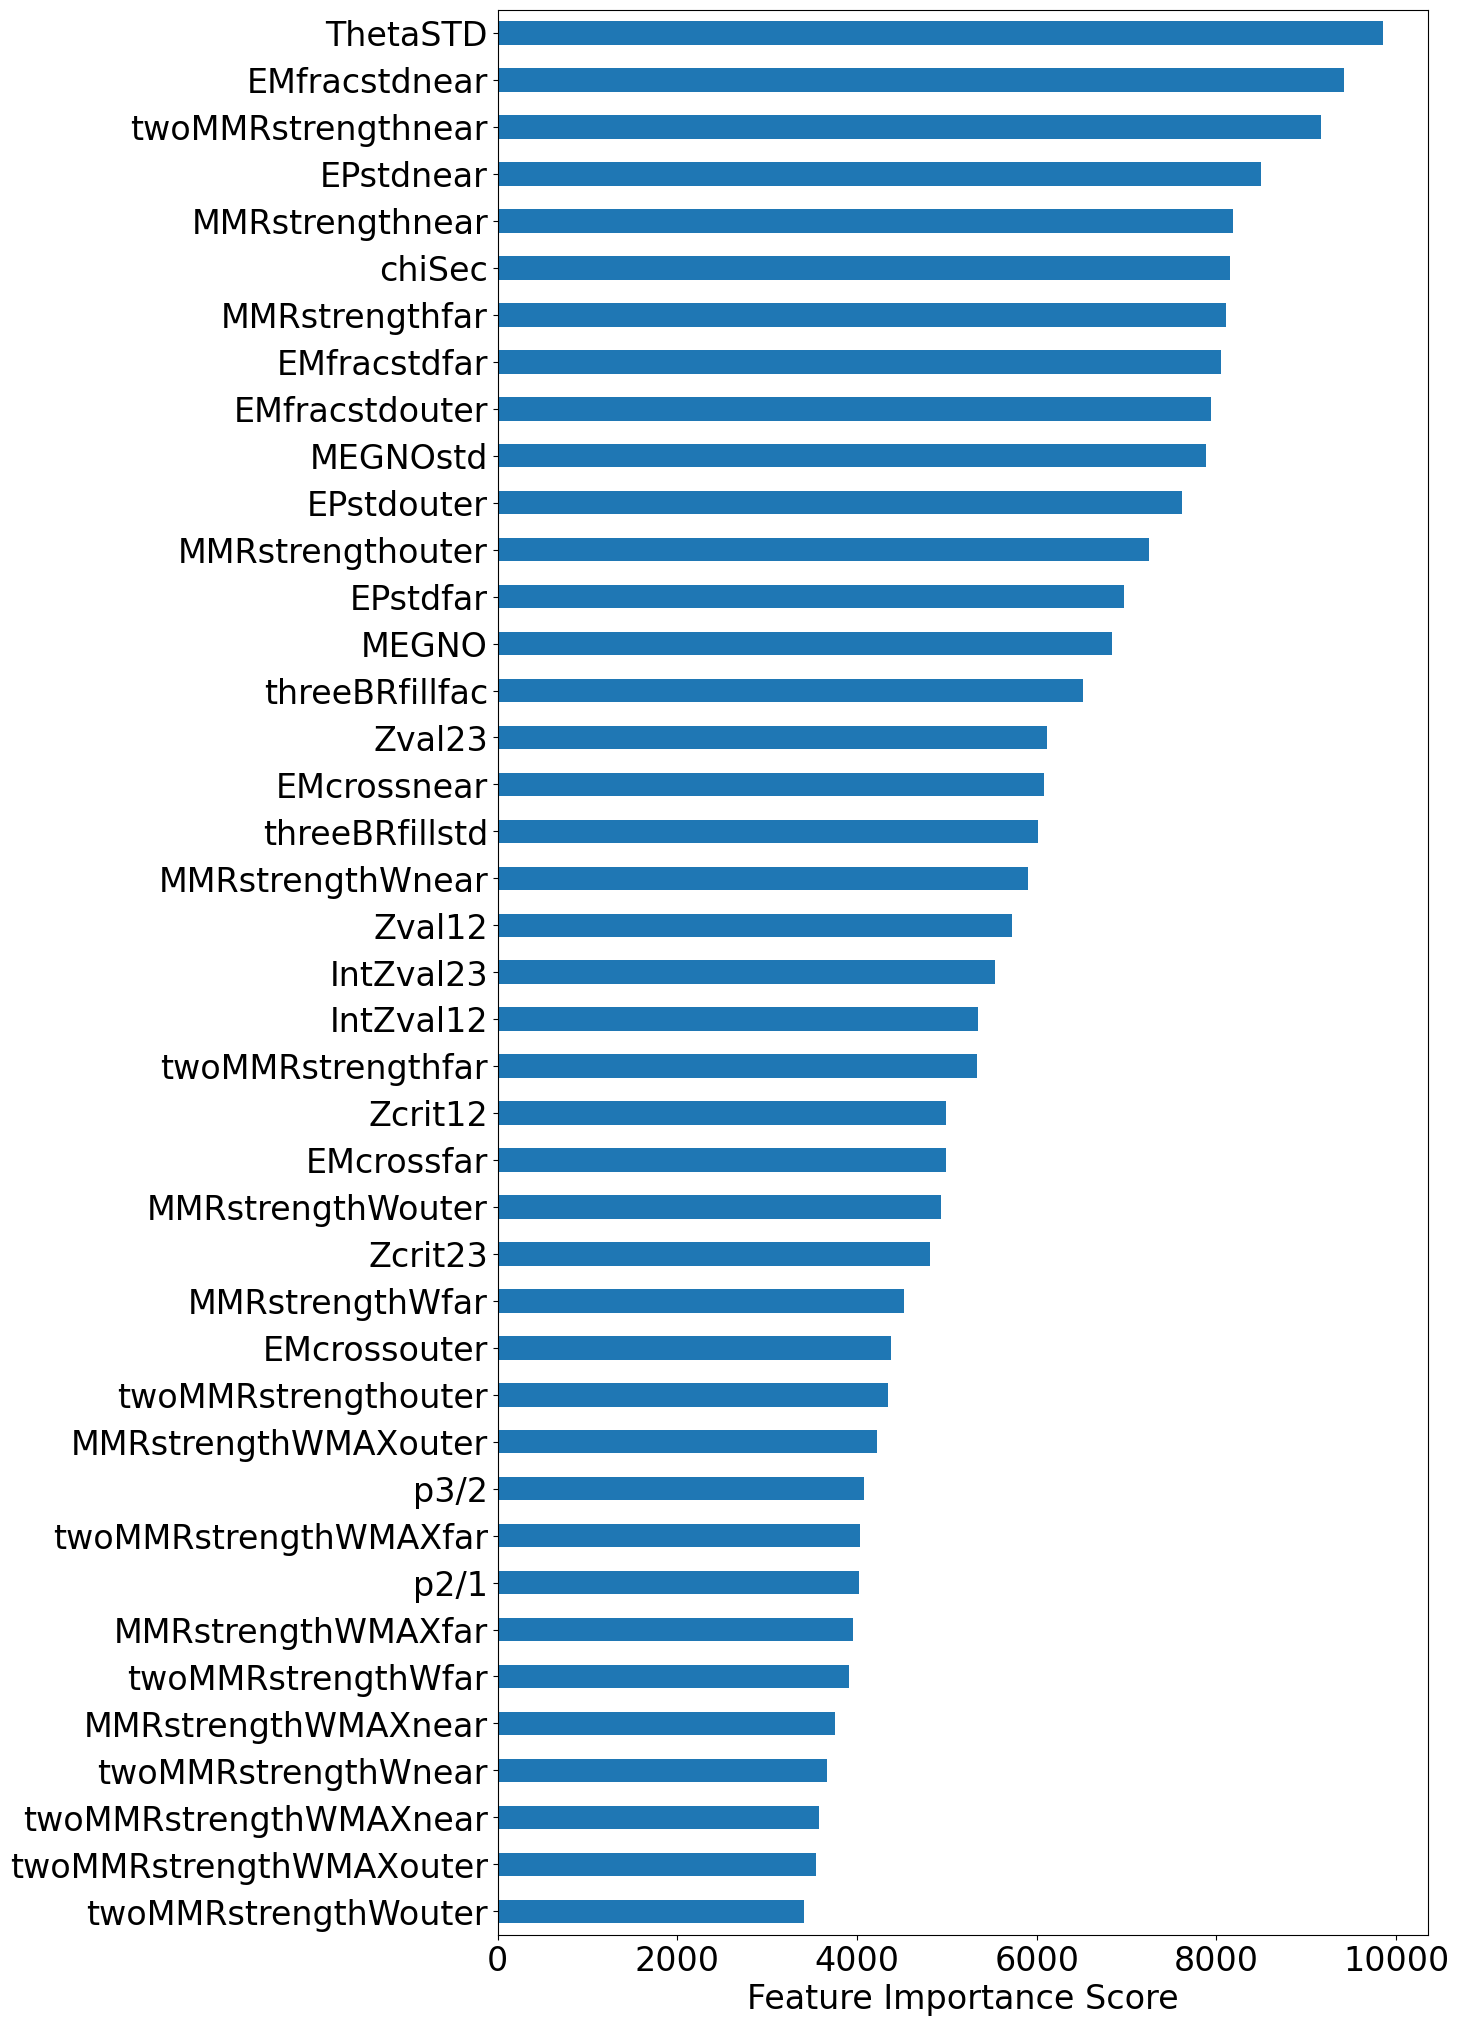

In [38]:
feat_imp = pd.Series(testModel.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,25), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')